In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)


# Load and process data

In [3]:
# read data from csv file
trainset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/trainset.csv')
testset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/testset.csv')
print(trainset.shape)
print(testset.shape)

(80000, 15)
(20000, 15)


In [4]:
trainset

,0_Ca,0_Cl,0_Na,0_K,0_N5,1_Ca,1_Cl,1_Na,1_K,1_N5,out_Ca,out_Cl,out_Na,out_K,out_N5
0,0.341575,1.159034,0.012636,0.451710,0.794808,0.347226,0.116634,0.755911,0.674340,1.359338,0.3233,1.1590,0.02901,0.4719,0.79480
1,0.638607,0.558054,1.231009,0.243433,1.132821,0.038278,0.185744,0.734268,1.464984,1.489907,0.4584,0.5581,1.24700,0.5882,1.13300
2,0.787981,0.763241,0.349968,0.738449,1.452716,1.117356,0.110285,0.393380,0.282715,1.466671,0.8053,0.7632,0.34980,0.7038,1.45300
3,0.466115,0.948450,0.942671,1.051085,1.358636,0.470234,0.252135,0.914662,1.318543,1.076570,0.4558,0.9484,0.94180,1.0730,1.35900
4,0.452663,0.644895,1.360873,0.991130,0.162887,1.361588,1.475943,0.637112,0.397679,1.414160,0.4939,0.6449,1.34300,0.9266,0.16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.796601,0.398041,1.132371,0.996845,0.094560,1.074895,1.055513,0.777877,0.870241,0.361988,0.8083,0.3980,1.12600,0.9802,0.09456
79996,0.942419,1.456538,1.164360,0.775981,0.069458,1.024540,1.025283,0.144121,1.438743,0.241862,0.9305,1.4570,1.15000,0.8141,0.06946
79997,1.095302,0.438446,1.335379,0.365207,0.273701,0.765942,0.880543,1.152310,1.119219,1.104459,1.0670,0.4384,1.33500,0.4223,0.27370
79998,0.310626,0.661302,0.192742,1.280823,0.931653,0.199012,0.072267,0.870017,0.563615,0.006399,0.3275,0.6613,0.21380,1.2260,0.93170


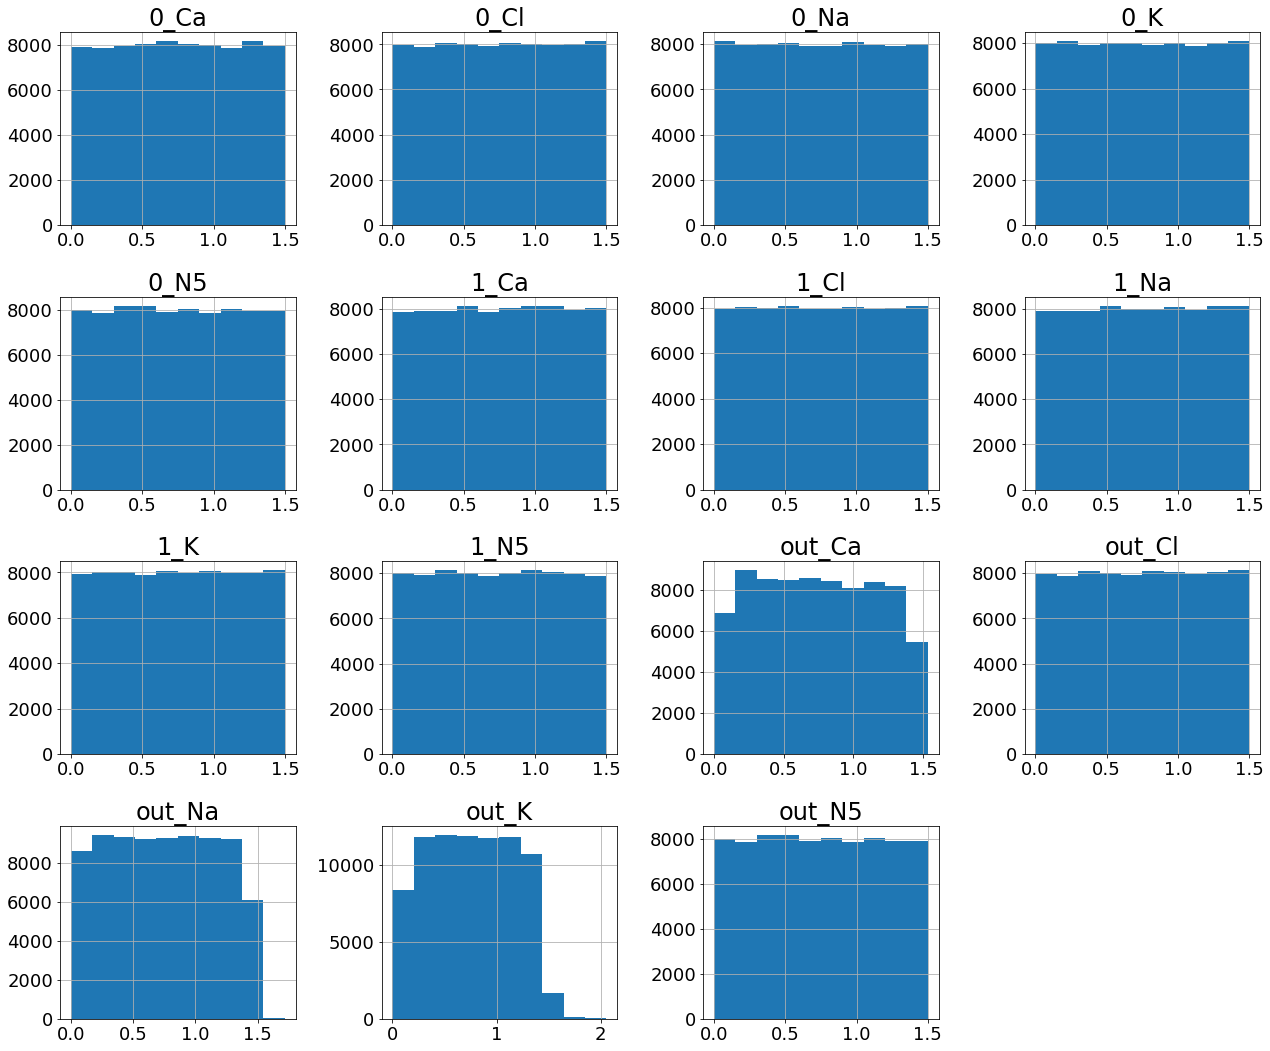

In [5]:
trainset.hist(figsize=(18, 15));
plt.tight_layout()

In [6]:
# split x and y
X_train = trainset.iloc[:, [0,2,3,5,7,8]].values 
y_train = trainset.iloc[:, [10, 12, 13]].values
X_test = testset.iloc[:, [0,2,3,5,7,8]].values 
y_test = testset.iloc[:, [10, 12, 13]].values

# Name variables
inputs = [list(trainset)[i] for i in [0,2,3,5,7,8]] 
outputs = [list(trainset)[i] for i in [10, 12, 13]] # do not work for list -> list(trainset)[10, 12, 13]

In [7]:
print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['0_Ca', '0_Na', '0_K', '1_Ca', '1_Na', '1_K']
Outputs:  ['out_Ca', 'out_Na', 'out_K']
X_train instances:  (80000, 6)
X_test instances:  (20000, 6)
y_train instances:  (80000, 3)
y_test instances:  (20000, 3)


## Normalize data

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

# Fine Tuning

## Tensorflow NN

In [20]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam

print(tf.__version__)

2.4.1


In [21]:
# for reproducibility
tf.random.set_seed(42) 
np.random.seed(42)  

INPUT_SIZE = 6
OUTPUT_SIZE = 3

# Model
def create_model(hiden_layers, neurons, dropout, kreg, activation, lactivation, lr):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(INPUT_SIZE,), activation=activation, kernel_regularizer=l2(kreg)))
    if dropout >1e-3:
        model.add(Dropout(dropout))
    for i in range(hiden_layers):
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(kreg)))
        if dropout >1e-3:
            model.add(Dropout(dropout))
    model.add(Dense(OUTPUT_SIZE, activation=lactivation))

    model.compile(loss='mean_squared_error',
                  optimizer= Adam(lr), # rmsprop, adam, sgd, adagrad
                  metrics=['mean_squared_error'])
    return model

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                               min_delta=0.0,
                                               patience=10,
                                               verbose=0,
                                               restore_best_weights=True)

In [22]:
start = time.time()
model = create_model(1,32,0.0,0.0,'relu','linear',1e-4)


history = model.fit(X_train_norm, 
          y_train, 
          epochs=100, 
          batch_size=256,
          validation_split=0.2,
          callbacks = [early_stopping])

reg_best = model
print('\n\nTime: ',time.time()-start)

Epoch 1/100


2022-05-11 16:29:16.782497: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


250/250 [==============================] - 2s 6ms/step - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.2620 - val_mean_squared_error: 0.2620
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.0933 - val_mean_squared_error: 0.0933
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 6/100
250/250 [==============================] - 2s 9ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 7/100
250/250 [=============

250/250 [==============================] - 1s 2ms/step - loss: 1.6567e-04 - mean_squared_error: 1.6567e-04 - val_loss: 2.0969e-04 - val_mean_squared_error: 2.0969e-04
Epoch 95/100
250/250 [==============================] - 1s 3ms/step - loss: 1.5804e-04 - mean_squared_error: 1.5804e-04 - val_loss: 2.0811e-04 - val_mean_squared_error: 2.0811e-04
Epoch 96/100
250/250 [==============================] - 1s 2ms/step - loss: 1.7855e-04 - mean_squared_error: 1.7855e-04 - val_loss: 2.0704e-04 - val_mean_squared_error: 2.0704e-04
Epoch 97/100
250/250 [==============================] - 1s 2ms/step - loss: 1.5704e-04 - mean_squared_error: 1.5704e-04 - val_loss: 2.0256e-04 - val_mean_squared_error: 2.0256e-04
Epoch 98/100
250/250 [==============================] - 1s 2ms/step - loss: 1.4770e-04 - mean_squared_error: 1.4770e-04 - val_loss: 1.9984e-04 - val_mean_squared_error: 1.9984e-04
Epoch 99/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4921e-04 - mean_squared_error: 1.49

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


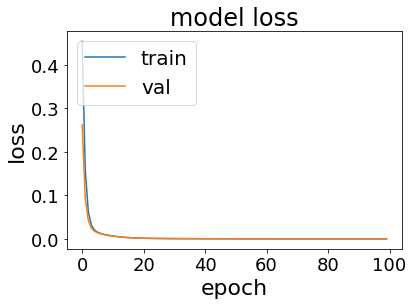

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'hiden_layers': [1, 2, 4],
     'batch_size': [128], 
     'neurons': [32, 64, 128, 256], 
     'dropout': [0.0, 0.1, 0.3],
     'kreg': [0.0, 1e-6, 1e-4],
     'activation': ['relu'], 
     'lactivation': ['linear'], #['linear','tanh'],
     'lr': [1e-2, 1e-3, 1e-4]   
    }]
    
model = KerasRegressor(build_fn=create_model,  epochs=300, verbose=0)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, 
                           verbose = 1,
                           n_jobs= 1)
start = time.time()
grid_search.fit(X_train_norm, y_train, callbacks = [early_stopping])
print("Run time = ", time.time()-start)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Run time =  110067.96388459206


In [25]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best score:      {-grid_search.best_score_:0.5f} (+/-{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:0.5f})")
 

best parameters: {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 256}
best score:      0.00003 (+/-0.00000)


In [26]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
23,"{'activation': 'relu', 'batch_size': 128, 'dro...",1,-0.000031,0.000005
11,"{'activation': 'relu', 'batch_size': 128, 'dro...",2,-0.000032,0.000005
44,"{'activation': 'relu', 'batch_size': 128, 'dro...",3,-0.000033,0.000007
9,"{'activation': 'relu', 'batch_size': 128, 'dro...",4,-0.000033,0.000006
22,"{'activation': 'relu', 'batch_size': 128, 'dro...",5,-0.000036,0.000002
...,...,...,...,...
315,"{'activation': 'relu', 'batch_size': 128, 'dro...",320,-0.009904,0.001670
192,"{'activation': 'relu', 'batch_size': 128, 'dro...",321,-0.010032,0.001451
312,"{'activation': 'relu', 'batch_size': 128, 'dro...",322,-0.014212,0.000933
300,"{'activation': 'relu', 'batch_size': 128, 'dro...",323,-0.018499,0.001413


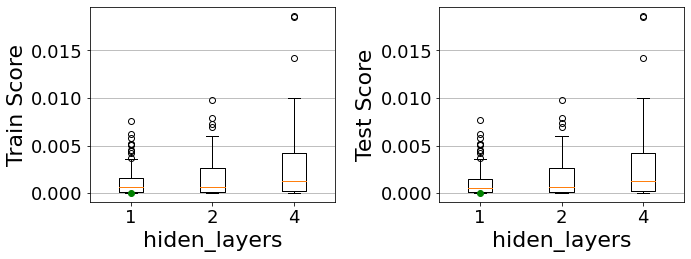

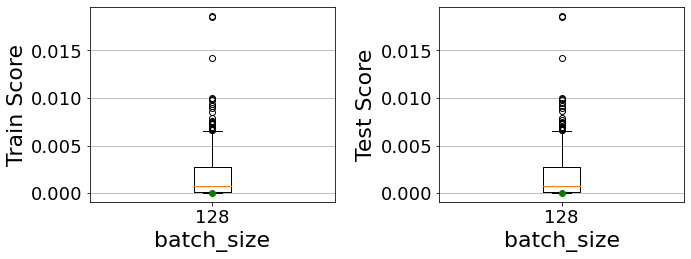

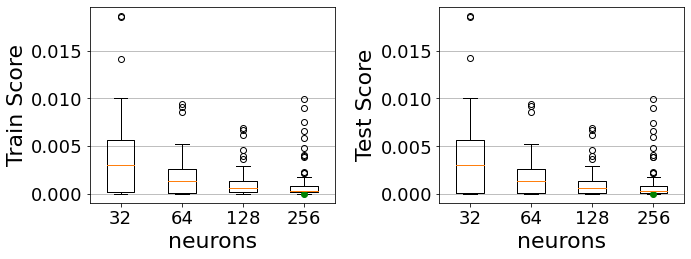

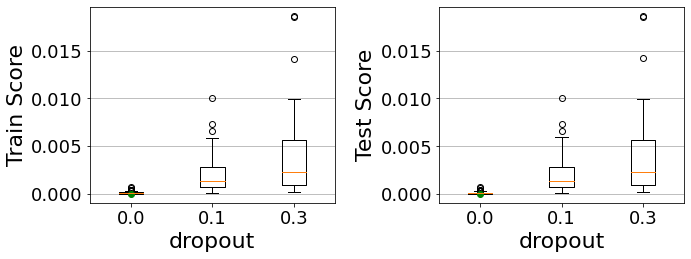

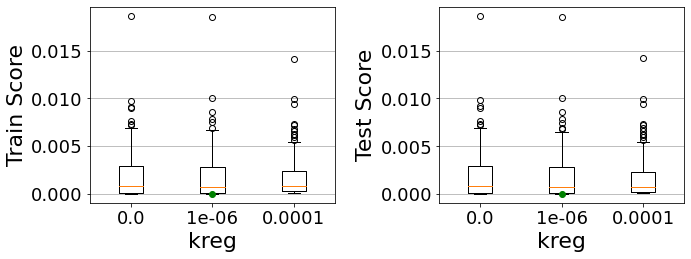

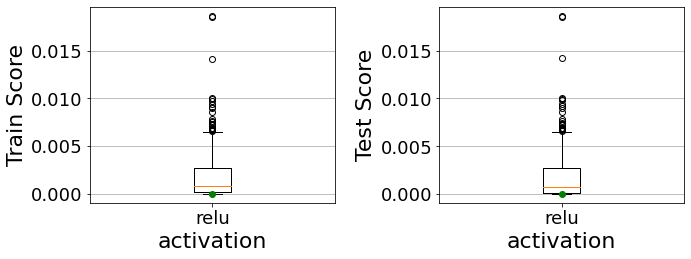

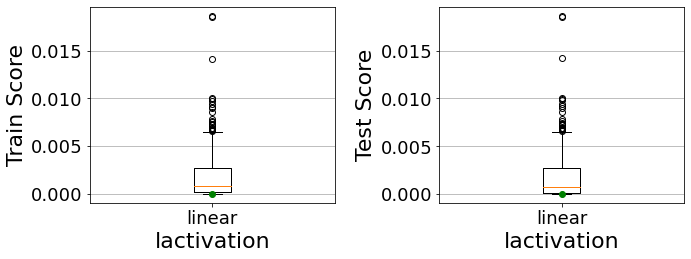

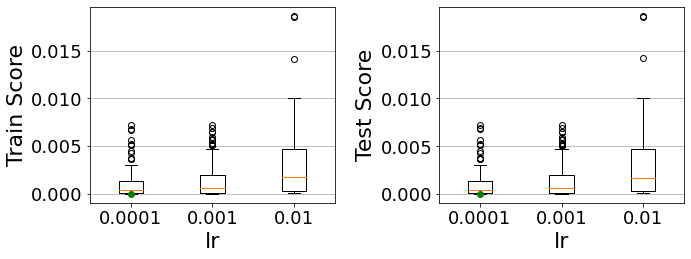

In [27]:
for param_name in param_grid[0]:

    params = sorted(results_df['param_' + param_name].unique())
    means_train = [-results_df[results_df['param_' + param_name] == p]['mean_train_score'] for p in params]
    means_test = [-results_df[results_df['param_' + param_name] == p]['mean_test_score'] for p in params]

    # plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    axes[0].boxplot(means_train)
    axes[0].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 'go')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Train Score')
    
    axes[1].boxplot(means_test)
    axes[1].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_test_score'][grid_search.best_index_], 'go')    
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('Test Score')
    
    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticks([x+1 for x in range(len(params))], labels=list(map(str, params)))
    
    plt.tight_layout()
    plt.show()

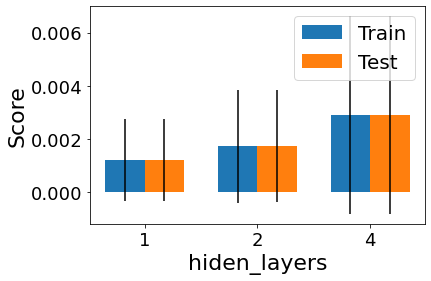

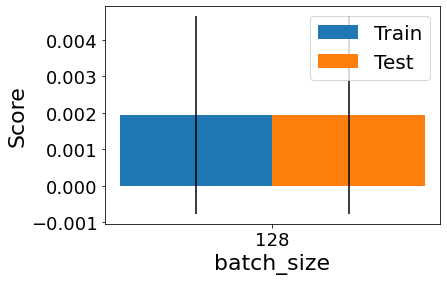

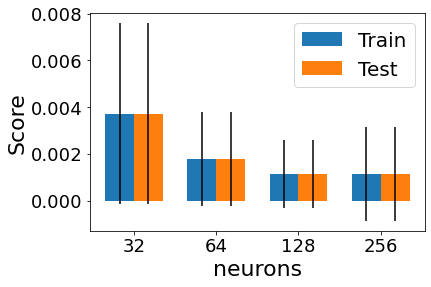

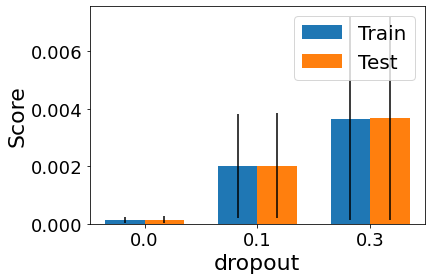

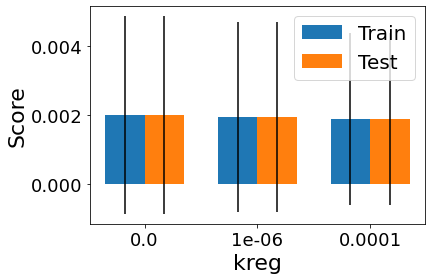

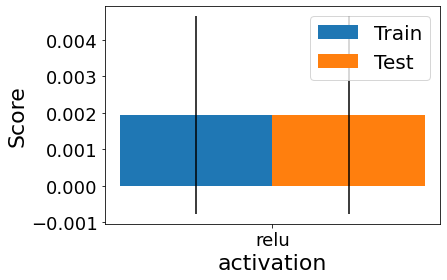

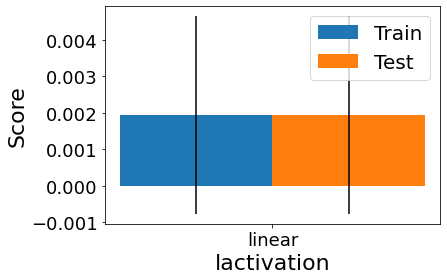

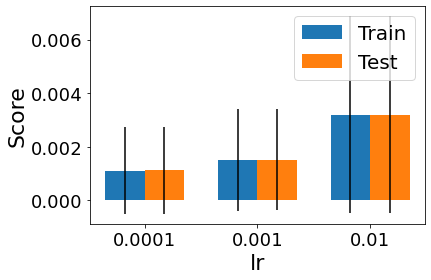

In [28]:
for param_name in param_grid[0]:
    
    results_dfg = results_df.groupby('param_' + param_name)
    params = results_dfg.groups.keys() # or params = results_df['param_' + param_name].unique()
    means_train = -results_dfg.mean()['mean_train_score']
    stds_train = results_dfg.std()['mean_train_score']
    means_test = -results_dfg.mean()['mean_test_score']
    stds_test = results_dfg.std()['mean_test_score']

    # plot
    fig, ax = plt.subplots()
    
    x = np.arange(len(params))  # the label locations
    width = 0.35  # the width of the bars

    ax.bar(x - width/2, means_train, width, yerr=stds_train, label = 'Train')
    ax.bar(x + width/2, means_test, width, yerr=stds_test, label = 'Test')
    ax.set_xticks(x, list(map(str, params)))
    ax.set_xlabel(param_name)
    ax.set_ylabel('Score')
    ax.legend()
    plt.show()

In [29]:
reg_best = grid_search.best_estimator_

print(grid_search.best_params_, end='\n')
print(grid_search.best_estimator_)

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 256}


In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.010661805770854406 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 0.0, 'lactivation': 'linear', 'lr': 0.01, 'neurons': 32}
0.011909262595196105 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 0.0, 'lactivation': 'linear', 'lr': 0.01, 'neurons': 64}
0.012018079026113515 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 0.0, 'lactivation': 'linear', 'lr': 0.01, 'neurons': 128}
0.01118732145595017 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 0.0, 'lactivation': 'linear', 'lr': 0.01, 'neurons': 256}
0.006929570423778618 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 0.0, 'lactivation': 'linear', 'lr': 0.001, 'neurons': 32}
0.008001517554272135 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 0.0, 'lactivation': 'linear', 'lr': 0.001, 'neurons': 64}
0.00750572417332637

In [31]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]), key=lambda cvres: cvres[0], reverse=False)

[(0.005592748800520478,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 1e-06,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 256}),
 (0.005641802062566013,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 0.0,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 256}),
 (0.005764351226626128,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 2,
   'kreg': 0.0,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 32}),
 (0.005785094078714515,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 0.0,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 64}),
 (0.005989502867577701,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 1e-06,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 128}),
 (0.005991401428821701,
  {'

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -0.38582897186279297

mse:  1.4871085695660182e-05
rmse:  0.0038563046684177045
mae:  0.0015036764324511372

R2:  0.9999127182675466


In [47]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -0.19319796562194824

mse:  2.5933034580454847e-05
rmse:  0.005092448780346725
mae:  0.001606595660029361

R2:  0.9998466559252455


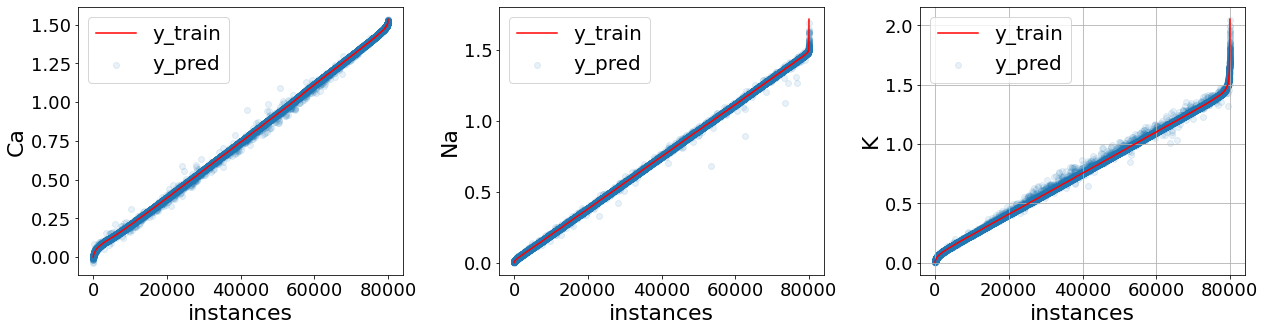

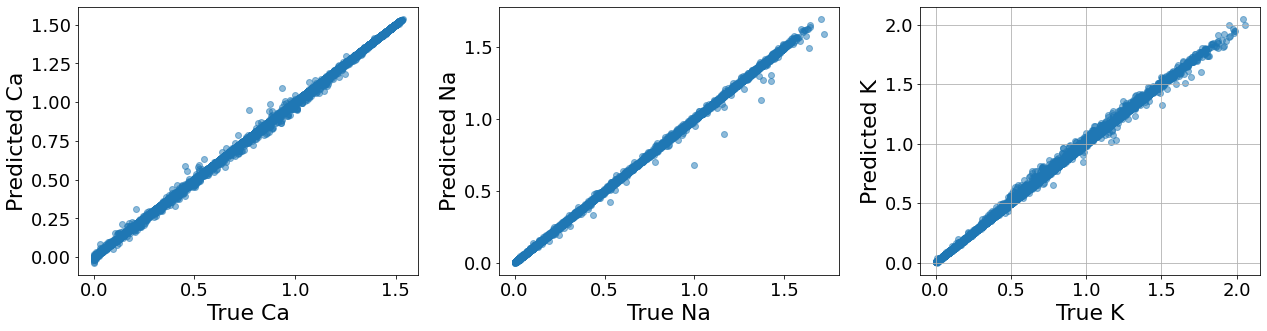

In [34]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_train[:,i]
    aux_pred = y_train_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_train[:,i], y_train_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

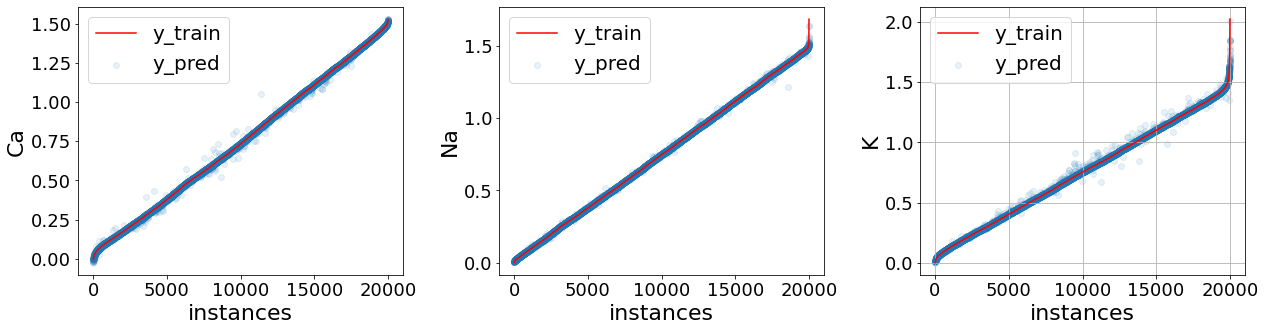

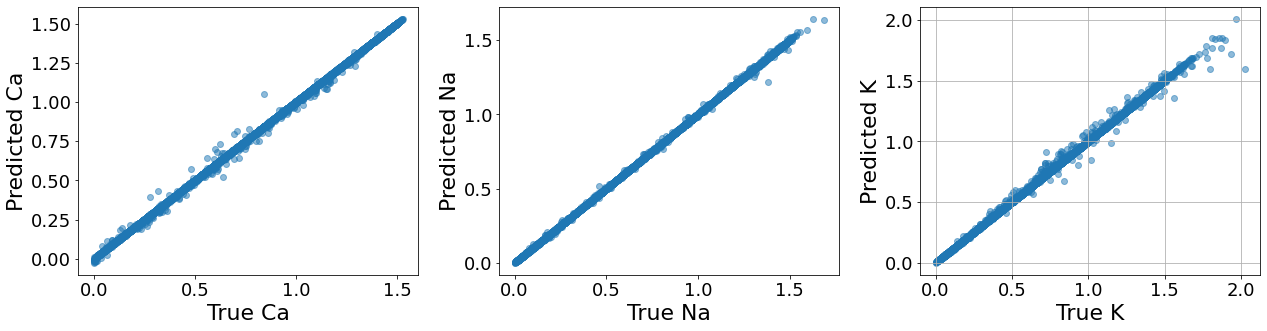

In [35]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_test[:,i]
    aux_pred = y_test_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[:,i], y_test_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

## Checking charge constraint

In [45]:
charge_in = 2*X_train[:, 0]+X_train[:, 1]+X_train[:, 2]
charge_out = 2*y_train_pred[:, 0]+y_train_pred[:, 1]+y_train_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.0026246625030749236

In [48]:
charge_in = 2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]
charge_out = 2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.00265731903711649

## Model persistence

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import load_model
grid_search.best_estimator_.model.save("NNmodel.h5")
NNmodel_loaded = load_model("NNmodel.h5") 

import joblib
joblib.dump(norm_pipeline, "norm_pipeline.pkl") 
#joblib.dump(ynorm_pipeline, "ynorm_pipeline.pkl") 
norm_pipeline_loaded = joblib.load("norm_pipeline.pkl")
#ynorm_pipeline_loaded = joblib.load("ynorm_pipeline.pkl")

print('rmse: ', np.sqrt(mean_squared_error(y_test,
                NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test)))))

rmse:  0.005092448852361709


In [50]:
# Add Physics-constrained

y_test_pred = NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test))
y_test_pred = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse:  0.005077146035719215
